In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import numpy as np 
env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)


/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [2]:
from gym.spaces import Box
from gym import Wrapper, ObservationWrapper
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation

class CustomWrapper(Wrapper):
    def reset(self, **kwargs):
        kwargs.pop('seed', None)  # Remove the 'seed' argument
        kwargs.pop('options', None)  # Remove the 'options' argument
        return self.env.reset(**kwargs)

# Wrap your environment
env = CustomWrapper(env)

class SkipFrame(Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info

    
class RemoveChannelDim(ObservationWrapper):
    def observation(self, observation):
        return np.squeeze(observation)
    
# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = RemoveChannelDim(env)
env = FrameStack(env, num_stack=4)


In [3]:
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import os

2023-06-12 23:49:47.536234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 23:49:48.527932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [5]:
CHECKPOINT_DIR = './dqn/train/'
LOG_DIR = './dqn/logs/'

In [6]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [7]:
import torch as th
import torch.nn as nn
from gymnasium import spaces

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=n_input_channels, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(3136, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, features_dim))
            #nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)


In [8]:
model = DQN('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.00001, 
            policy_kwargs=policy_kwargs, buffer_size=80000) 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/edu/anaconda3/envs/tp_ap/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [9]:
from stable_baselines3.common.logger import configure

def train_model():
    env.reset()
    new_logger = configure(LOG_DIR, ["stdout", "csv"])
    # Set new logger 
    model.set_logger(new_logger)

    model.learn(total_timesteps=100000, callback=callback)

#train_model()

In [10]:
model.save('dqn_test_model')

In [11]:
#env.close()

In [12]:
from stable_baselines3.common.evaluation import evaluate_policy

model = DQN.load("dqn/train/best_model_100000")
obs = env.reset()

print(evaluate_policy(model, env, n_eval_episodes=10, deterministic=False, render=True))

print("Done.")


Done.


In [13]:
env.close()

In [14]:
import pandas as pd

df = pd.read_csv("dqn/logs/progress.csv")
df

,rollout/exploration_rate,time/episodes,rollout/ep_rew_mean,time/total_timesteps,time/fps,time/time_elapsed,rollout/ep_len_mean
0,0.05,4,1537.500000,4443,88,50,1110.750000
1,0.05,8,1801.250000,8435,90,93,1054.375000
2,0.05,12,1753.750000,12969,90,143,1080.750000
3,0.05,16,1784.250000,18448,86,213,1153.000000
4,0.05,20,1817.350000,21350,86,246,1067.500000
5,0.05,24,1827.666667,25120,86,291,1046.666667
6,0.05,28,1764.750000,26830,86,311,958.214286
7,0.05,32,1821.218750,30229,85,352,944.656250
8,0.05,36,1796.916667,34959,85,407,971.083333
9,0.05,40,1776.350000,39512,85,460,987.800000


In [15]:
df = df.fillna(0)
df

,rollout/exploration_rate,time/episodes,rollout/ep_rew_mean,time/total_timesteps,time/fps,time/time_elapsed,rollout/ep_len_mean
0,0.05,4,1537.500000,4443,88,50,1110.750000
1,0.05,8,1801.250000,8435,90,93,1054.375000
2,0.05,12,1753.750000,12969,90,143,1080.750000
3,0.05,16,1784.250000,18448,86,213,1153.000000
4,0.05,20,1817.350000,21350,86,246,1067.500000
5,0.05,24,1827.666667,25120,86,291,1046.666667
6,0.05,28,1764.750000,26830,86,311,958.214286
7,0.05,32,1821.218750,30229,85,352,944.656250
8,0.05,36,1796.916667,34959,85,407,971.083333
9,0.05,40,1776.350000,39512,85,460,987.800000


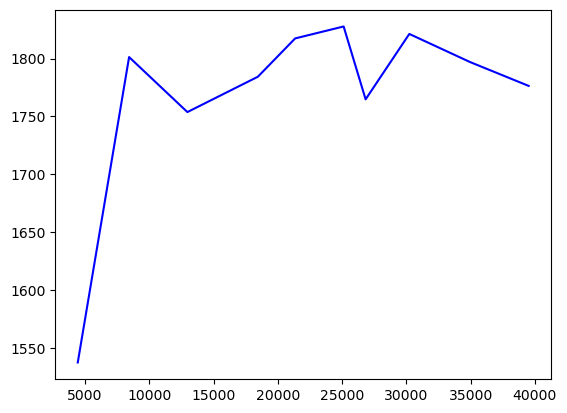

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
xpoints = np.array(df['time/total_timesteps'].to_numpy())
ypoints = np.array(df['rollout/ep_rew_mean'].to_numpy())
plt.plot(xpoints, ypoints, color = 'b')
plt.show()
plt.savefig('dqn/plots/mean_reward.png')
plt.clf()

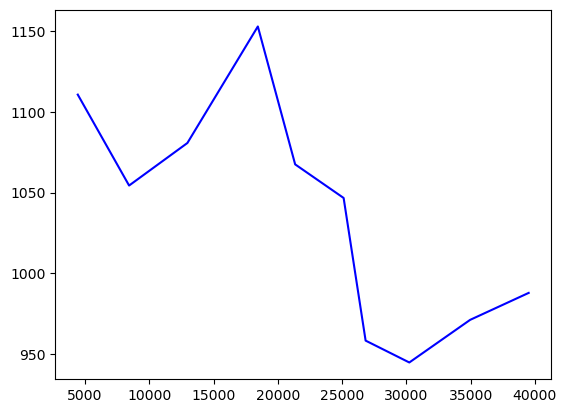

<Figure size 640x480 with 0 Axes>

In [17]:
xpoints_len = np.array(df['time/total_timesteps'].to_numpy())
ypoints_len = np.array(df['rollout/ep_len_mean'].to_numpy())
plt.plot(xpoints_len, ypoints_len, color = 'b')
plt.show()
plt.savefig('dqn/plots/length.png')
plt.clf()